In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [9]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder

## params

In [4]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
transformer_path = data_folder + 'best_model_20240318_lib_cos_sim.ckpt'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [6]:
config=Config()

## open janssen data

In [7]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [8]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

python(79255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|                                                                                                                                                                 | 2033/100000000 [00:01<20:38:44, 1345.42it/s]


We reached the end of the array at index 2033


## open training data

In [9]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']
molecule_pairs_test= dataset['molecule_pairs_test']

In [10]:
molecule_pairs_train

##  Select one spectra from the Janssen as target

In [11]:
target_spectra= all_spectrums_janssen[0]

In [13]:
target_spectra.params

{'pepmass': (380.2683, None),
 'rt': '5.51',
 'ionmode': 'Positive',
 'adduct': 'M+',
 'charge': [1],
 'id': 'DNYBIOICMDTDAP',
 'smiles': 'CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1',
 'formula': 'C22H32N6',
 'filename': '2600129002_190419_MAS011_A1.mzXML',
 'drugbank.id': 'Unknown',
 'inchikey': 'DNYBIOICMDTDAP-UHFFFAOYSA-N',
 'cpd': 'BS-181',
 'status': 'experimental',
 'cas': 'N/A',
 'name': 'BS-181',
 'mslevel': '2',
 'tic': '71384813.4375',
 'pepmass_dev': '0.00101425948357327',
 'scan_number': '517',
 'param_submit_user': '',
 'param_sample_type': '',
 'param_comments': '',
 'param_algorithm': 'RMassBank',
 'param_creation_time': '2021-06-26 21:49:30',
 'scans': '3',
 'db': 'Inhouse',
 'class': 'Pyrazolopyrimidines',
 'num_peaks': '52',
 'param_consensus': 'consensus',
 'superclass': 'Organoheterocyclic compounds',
 'subclass': 'Pyrazolo[1,5-a]pyrimidines'}

## Create pairs with this spectra

In [75]:
spectrums_base= molecule_pairs_train.spectrums_original + molecule_pairs_val.spectrums_original + molecule_pairs_test.spectrums_original

NameError: name 'molecule_pairs_val' is not defined

In [14]:
total_spectra= [all_spectrums_janssen[0]] +spectrums_base

In [29]:
import pandas as pd
df_smiles = pd.DataFrame()
df_smiles['indexes']= [[ind] for ind in np.arange(0,len(spectrums_base)+1)]

In [30]:
indexes_tani=np.zeros((len(spectrums_base),3))

In [31]:
indexes_tani[:,1] =  np.arange(0,len(spectrums_base))

In [32]:
discovery_pairs = MoleculePairsOpt(
                        spectrums_unique = total_spectra,
                        spectrums_original = total_spectra,
                        indexes_tani_unique=indexes_tani,
                        df_smiles=df_smiles,
)

In [34]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [35]:
scores_trans=model.predict_from_molecule_pair(discovery_pairs)

Preprocessing all the data ...


261350it [00:05, 50877.76it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261349/261349 [00:02<00:00, 102966.28it/s]


Preprocessing all the data ...


261350it [00:03, 72410.69it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [36]:
scores_trans

array([0.99999982, 0.3843779 , 0.26581323, ..., 0.24664937, 0.24323639,
       0.29153156])

## Assign predictions

In [38]:
discovery_pairs.pred = scores_trans

## Which are the spectra that are closer to this compound?

(array([4.1097e+04, 8.8217e+04, 8.3873e+04, 3.3161e+04, 9.3920e+03,
        3.5670e+03, 1.5060e+03, 3.9600e+02, 1.3200e+02, 8.0000e+00]),
 array([0.01155352, 0.11039815, 0.20924278, 0.30808741, 0.40693204,
        0.50577667, 0.6046213 , 0.70346593, 0.80231056, 0.90115519,
        0.99999982]),
 <BarContainer object of 10 artists>)

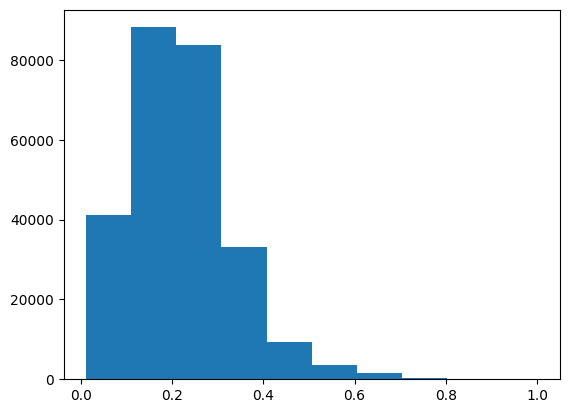

In [40]:
import matplotlib.pyplot as plt
plt.hist(scores_trans)

In [66]:
possible_spectra= [m for m,s in zip(discovery_pairs, scores_trans) if s>0.90]

In [67]:
len(possible_spectra)

8

In [68]:
target_smiles= 'CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1'

In [69]:
possible_spectra[1].params_1

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [381.2761],
 'ionmode': 'Positive',
 'name': ' 6-Aminohexyl-[7-(benzylamino)-3-isopropylpyrazolo[1,5-a]pyrimidin-5-yl]amine\n M+H',
 'inchi': 'N/A',
 'smiles': 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'organism': 'nist',
 'spectrumid': 'abcd'}

In [70]:
[s.smiles_1 for s in possible_spectra]

['CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN',
 'CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN']

## Check results

In [71]:
from src.tanimoto import Tanimoto


In [1]:
Tanimoto.compute_tanimoto_from_smiles('CC(C)c1cnn2c(cc(NCCCCCCN)nc12)NCc1ccccc1','CC(C)C1=C2N=C(C=C(N2N=C1)NCC3=CC=CC=C3)NCCCCCCN')

NameError: name 'Tanimoto' is not defined

In [5]:
from matchms.importing import load_from_mgf,load_from_msp
all_spectrums_janssen_spec2vec = [(s) for s in load_from_mgf(janssen_path)]

2024-03-21 11:39:10,848:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,852:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,855:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,857:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,858:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,860:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,862:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,864:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,866:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,867:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,869:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 11:39:10,870:WARNING:matchms:add

In [13]:
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'

In [12]:
from src.spec2vec_comparison import Spec2VecComparison
for i in (range(len(all_spectrums_janssen_spec2vec))):
    all_spectrums_janssen_spec2vec[i] = Spec2VecComparison.spectrum_processing(all_spectrums_janssen_spec2vec[i])

In [14]:
spec2vec_similarity =Spec2VecComparison.get_spec2vec_similarity(model_spec2vec_file)

In [15]:
nist_path = data_folder + 'hr_msms_nist_all.MSP'

In [16]:
all_spectrums_nist_MATCHMS = [(s) for s in load_from_msp(nist_path)]

In [ ]:
from src.spec2vec_comparison import Spec2VecComparison
for i in (range(len(all_spectrums_nist_MATCHMS))):
    all_spectrums_nist_MATCHMS[i] = Spec2VecComparison.spectrum_processing(all_spectrums_nist_MATCHMS[i])

2024-03-21 11:49:10,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:10,039:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:10,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:10,041:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:10,043:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:10,043:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:10,044:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:49:13,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:13,485:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:13,485:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:13,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:13,487:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:13,488:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:13,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mas

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:49:16,931:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:16,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:16,932:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:16,934:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:16,934:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:49:16,935:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:49:16,935:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mas

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:52:27,352:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:52:27,352:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:52:27,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:52:27,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:52:27,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:52:27,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:52:27,370:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:55:21,639:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:55:21,639:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:55:21,643:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:55:21,643:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:55:21,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:55:21,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:55:21,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:57:16,394:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:57:16,395:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:57:16,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:57:16,405:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:57:16,419:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:57:16,419:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:57:16,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 11:59:52,147:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:59:52,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:59:52,151:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:59:52,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:59:52,153:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 11:59:52,156:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 11:59:52,156:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mas

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-03-21 12:02:21,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 12:02:21,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 12:02:21,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 12:02:21,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 12:02:21,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 12:02:21,567:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 12:02:21,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

In [ ]:
score = calculate_scores(
                    all_spectrums_janssen_spec2vec, all_spectrums_nist_MATCHMS, spec2vec_similarity
                )

                

In [ ]:
score.shape

In [ ]:
score